
# Benchmark Compairison between EKF, UKF, EnKF, and SIF


This example shows how multiple trackers can be compared against each other using the same
set of detections.



This notebook creates groundtruth with manoeuvring motion, generates detections using a sensor,
and attempts to track the groundtruth using the
Extended Kalman Filter (EKF), Unscented Kalman Filter (UKF), Stochastic Integration Filter (SIF), the Ensemble Kalman Filter, and
the Particle Filter (PF)

Each of these trackers assumes a constant velocity transition model. The trackers are compared
against each other using distance-error metrics, with the capability of displaying other metrics
for the user to explore.

## Layout
The layout of this example is as follows:

1) The ground truth is created using multiple transition models
2) The non-linear detections are generated once per time step using a bearing-range sensor
3) Each tracker is initialised and run on the detections
4) The results are plotted, and tracking metrics displayed for the user to explore
5) Weakly Nonlinear Simulation, constant velocity model, Bearing Range radar type measurement model.


## 1) Create Groundtruth
Firstly, we initialise the ground truth states:



In [36]:
import numpy as np
import datetime
from stonesoup.types.array import StateVector, CovarianceMatrix
from stonesoup.types.state import State, GaussianState

start_time = datetime.datetime.now()
#np.random.seed(4)
rng = np.random.default_rng()
initial_x = rng.uniform(-10,0)
initial_xv = rng.uniform(0,2.5)
initial_y = rng.uniform(30,40)
initial_yv = rng.uniform(-2.5,2.5)

initial_state_mean = StateVector([[initial_x], [initial_xv], [initial_y], [initial_yv]])
initial_state_covariance = CovarianceMatrix(np.diag([1, 0, 1, 0]))
timestep_size = datetime.timedelta(seconds=1)
number_steps = 50
initial_state = GaussianState(initial_state_mean, initial_state_covariance)

Next, we initialise the transition models used to generate the ground truth. Here, we say that
the targets will mostly go straight ahead with a constant velocity, but will sometimes turn
left or right. This is implemented using the :class:`~.SwitchMultiTargetGroundTruthSimulator`.



In [37]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity

# initialise the transition models the ground truth can use
q_x = 0.05
q_y = 0.05
transition_model = CombinedLinearGaussianTransitionModel(
    [ConstantVelocity(q_x), ConstantVelocity(q_y)])

Now we have initialised everything, we can generate the ground truth. Here we use a Single Target simulator.



In [38]:
from stonesoup.simulator.simple import SingleTargetGroundTruthSimulator
from stonesoup.types.state import GaussianState
# generate truths
ground_truth_gen = SingleTargetGroundTruthSimulator(
    transition_model=transition_model,
    initial_state=initial_state,
    timestep=timestep_size,
    number_steps=number_steps,
)

## 2) Generate detections using a bearing-range sensor

The next step is to create a sensor and use it to generate detections from the targets.
The sensor we use in this example is a radar with imperfect measurements in bearing-range space.

First we initialise the radar:



In [39]:
from stonesoup.sensor.radar import RadarBearingRange

# Create the sensor
sensor = RadarBearingRange(
    ndim_state=4,
    position_mapping=[0, 2],  # Detecting x and y
    noise_covar=np.diag([np.radians(0.2), 0.1]),  # 3 Degrees error in bearing, Error in Range
    clutter_model=None,  # Can add clutter model in future if desired
)

Now we place the sensor into the simulation:



In [40]:
from stonesoup.platform import FixedPlatform
platform = FixedPlatform(State(StateVector([0, 0, 0, 0])), position_mapping=[0, 2], # 40
                         sensors=[sensor])

Now we run the sensor and create detections:



In [41]:
from itertools import tee
from stonesoup.simulator.platform import PlatformDetectionSimulator

detector = PlatformDetectionSimulator(ground_truth_gen, platforms=[platform])
detector, *detectors = tee(detector, 6)
# Enables multiple trackers to run on the same detections

We put the detections and ground truths into sets so that we can plot them:



In [42]:
detections = set()
ground_truth = set()

for time, dets in detector:
    detections |= dets
    ground_truth |= ground_truth_gen.groundtruth_paths

And now we plot the ground truth and detections:



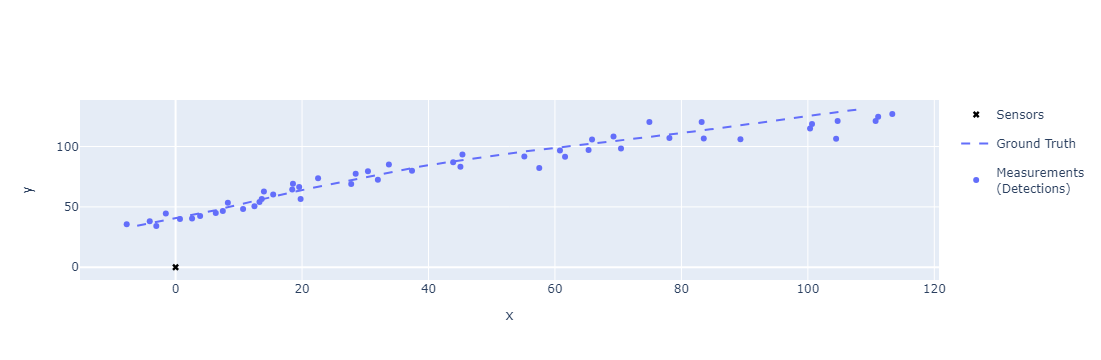

In [43]:
from stonesoup.plotter import Plotterly

plotter = Plotterly()
plotter.plot_ground_truths(ground_truth, [0, 2])
plotter.plot_measurements(detections, [0, 2])
plotter.plot_sensors(sensor)
plotter.fig

## 3) Initialise and run each tracker on the detections
With the detections now generated, our focus turns to creating and running the trackers.
This section of the notebook is quite long because each tracker requires an initiator, deleter,
detector, data associator, and updater. However, all of these things are standard
stonesoup building blocks.

Firstly, we approximate the transition model of the target. Here we assume a constant
velocity model,
which will be wrong due to the fact that we designed the targets to sometimes turn left or right.
We do this to test how effectively each tracking algorithm can perform against
target behaviour that doesn't move exactly as predicted.



In [44]:
transition_model_estimate = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.5),
                                                                   ConstantVelocity(0.5)])
# Tracking algorithm incorrectly estimates the type of path the truth takes

Next, we initialise the predictors, updaters, hypothesisers, data associators, and deleter.
The particle filter requires a resampler as part of its updater.
Note that the ESIF is a slight extension of the EKF and uses an EKF predictor.



In [45]:
from stonesoup.predictor.kalman import ExtendedKalmanPredictor, UnscentedKalmanPredictor, SIFKalmanPredictor
from stonesoup.predictor.particle import ParticlePredictor
from stonesoup.predictor.ensemble import EnsemblePredictor

# introduce the predictors
predictor_EKF = ExtendedKalmanPredictor(transition_model_estimate)
predictor_UKF = UnscentedKalmanPredictor(transition_model_estimate)
predictor_SIF = SIFKalmanPredictor(transition_model_estimate)
predictor_EnKF = EnsemblePredictor(transition_model_estimate)
predictor_PF = ParticlePredictor(transition_model_estimate)

# ######################################################################

from stonesoup.resampler.particle import ESSResampler
resampler = ESSResampler()

# ######################################################################

from stonesoup.updater.kalman import ExtendedKalmanUpdater, UnscentedKalmanUpdater, SIFKalmanUpdater
from stonesoup.updater.particle import ParticleUpdater
from stonesoup.updater.ensemble import EnsembleUpdater
# introduce the updaters

updater_EKF = ExtendedKalmanUpdater(sensor)
updater_UKF = UnscentedKalmanUpdater(sensor)
updater_SIF = SIFKalmanUpdater(sensor)
updater_EnKF = EnsembleUpdater(sensor)
updater_PF = ParticleUpdater(measurement_model=None, resampler=resampler)

# ######################################################################

from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
# introduce the hypothesisers
hypothesiser_EKF = DistanceHypothesiser(predictor_EKF, updater_EKF,
                                        measure=Mahalanobis(), missed_distance=4)
hypothesiser_UKF = DistanceHypothesiser(predictor_UKF, updater_UKF,
                                        measure=Mahalanobis(), missed_distance=4)
hypothesiser_SIF = DistanceHypothesiser(predictor_SIF, updater_SIF,
                                      measure=Mahalanobis(), missed_distance=4)
hypothesiser_EnKF = DistanceHypothesiser(predictor_EnKF, updater_EnKF,
                                      measure=Mahalanobis(), missed_distance=4)
hypothesiser_PF = DistanceHypothesiser(predictor_PF, updater_PF,
                                      measure=Mahalanobis(), missed_distance=4)

# ######################################################################

from stonesoup.dataassociator.neighbour import GNNWith2DAssignment
# introduce the data associators

data_associator_EKF = GNNWith2DAssignment(hypothesiser_EKF)
data_associator_UKF = GNNWith2DAssignment(hypothesiser_UKF)
data_associator_SIF = GNNWith2DAssignment(hypothesiser_SIF)
data_associator_EnKF = GNNWith2DAssignment(hypothesiser_EnKF)
data_associator_PF = GNNWith2DAssignment(hypothesiser_PF)

# ######################################################################

from stonesoup.deleter.time import UpdateTimeDeleter
# create a deleter
deleter = UpdateTimeDeleter(datetime.timedelta(seconds=5), delete_last_pred=True)

Now we introduce the initial predictors which will be used in the data associator
in the track initiators:



In [46]:
init_transition_model = CombinedLinearGaussianTransitionModel(
    (ConstantVelocity(q_x), ConstantVelocity(q_x))) # 0.05
init_predictor_EKF = ExtendedKalmanPredictor(init_transition_model)
init_predictor_UKF = UnscentedKalmanPredictor(init_transition_model)
init_predictor_SIF = SIFKalmanPredictor(init_transition_model)
init_predictor_EnKF = EnsemblePredictor(init_transition_model)
init_predictor_PF = ParticlePredictor(init_transition_model)

The final step before running the trackers is to create the initiators:



In [47]:
from stonesoup.initiator.simple import MultiMeasurementInitiator
# ######################################################################

initiator_EKF = MultiMeasurementInitiator(
    GaussianState(
        np.array([[20], [0], [10], [0]]),  # Prior State
        np.diag([1, 1, 1, 1])),
    measurement_model=None,
    deleter=deleter,
    data_associator=GNNWith2DAssignment(
        DistanceHypothesiser(init_predictor_EKF, updater_EKF, Mahalanobis(), missed_distance=5)),
    updater=updater_EKF,
    min_points=2
)
# ######################################################################

initiator_UKF = MultiMeasurementInitiator(
    GaussianState(
        np.array([[20], [0], [10], [0]]),  # Prior State
        np.diag([1, 1, 1, 1])),
    measurement_model=None,
    deleter=deleter,
    data_associator=GNNWith2DAssignment(
        DistanceHypothesiser(init_predictor_UKF, updater_UKF, Mahalanobis(), missed_distance=5)),
    updater=updater_UKF,
    min_points=2
)

############################################################################

initiator_SIF = MultiMeasurementInitiator(
    GaussianState(
        np.array([[20], [0], [10], [0]]),  # Prior State
        np.diag([1, 1, 1, 1])),
    measurement_model=None,
    deleter=deleter,
    data_associator=GNNWith2DAssignment(
        DistanceHypothesiser(init_predictor_SIF, updater_SIF, Mahalanobis(), missed_distance=5)),
    updater=updater_SIF,
    min_points=2
)

############################################################################



The initiators for the Particle and Ensemble Kalman filters work differently, so is shown below for clarity:



In [48]:
from stonesoup.initiator.simple import GaussianParticleInitiator, EnsembleInitiator
from stonesoup.types.state import GaussianState
from stonesoup.initiator.simple import SimpleMeasurementInitiator

prior_state = GaussianState(
    StateVector([20, 0, 10, 0]),
    np.diag([1, 1, 1, 1]) ** 2)

initiator_Part = SimpleMeasurementInitiator(prior_state, measurement_model=None,
                                            skip_non_reversible=True)

initiator_Ensemble = SimpleMeasurementInitiator(prior_state, measurement_model=None,
                                            skip_non_reversible=True)

number_particles = 2500 # 2500
initiator_PF = GaussianParticleInitiator(number_particles=number_particles,
                                        initiator=initiator_Part,
                                        use_fixed_covar=False)
ensemble_size = 2500 # 2500
initiator_EnKF = EnsembleInitiator(ensemble_size = ensemble_size,
                                   initiator=initiator_Ensemble)

Now we run the trackers and store the tracks in sets for plotting:



In [49]:
from stonesoup.tracker.simple import MultiTargetTracker

# #######################################################################

kalman_tracker_EKF = MultiTargetTracker(
    initiator=initiator_EKF,
    deleter=deleter,
    detector=detectors[0],
    data_associator=data_associator_EKF,
    updater=updater_EKF,
)
tracks_EKF = set()
for step, (time, current_tracks) in enumerate(kalman_tracker_EKF, 1):
    tracks_EKF.update(current_tracks)


# #######################################################################

kalman_tracker_UKF = MultiTargetTracker(
    initiator=initiator_UKF,
    deleter=deleter,
    detector=detectors[1],
    data_associator=data_associator_UKF,
    updater=updater_UKF,
)

tracks_UKF = set()
for step, (time, current_tracks) in enumerate(kalman_tracker_UKF, 1):
    tracks_UKF.update(current_tracks)

# ##########################################################################

kalman_tracker_SIF = MultiTargetTracker(
    initiator=initiator_SIF,
    deleter=deleter,
    detector=detectors[2],
    data_associator=data_associator_SIF,
    updater=updater_SIF,
)

tracks_SIF = set()
for step, (time, current_tracks) in enumerate(kalman_tracker_SIF, 1):
    tracks_SIF.update(current_tracks)
# ##########################################################################

tracker_EnKF = MultiTargetTracker(
    initiator=initiator_EnKF,
    deleter=deleter,
    detector=detectors[3],
    data_associator=data_associator_EnKF,
    updater=updater_EnKF,
)
#tracks_EnKF = set()
#for step, (time, current_tracks) in enumerate(tracker_EnKF, 1):
#    tracks_EnKF.update(current_tracks)

# ##########################################################################

tracker_PF = MultiTargetTracker(
    initiator=initiator_PF,
    deleter=deleter,
    detector=detectors[4],
    data_associator=data_associator_PF,
    updater=updater_PF,
)

tracks_PF = set()
for step, (time, current_tracks) in enumerate(tracker_PF, 1):
    tracks_PF.update(current_tracks)

Create initial states for tracks.

Finally, we plot the results:



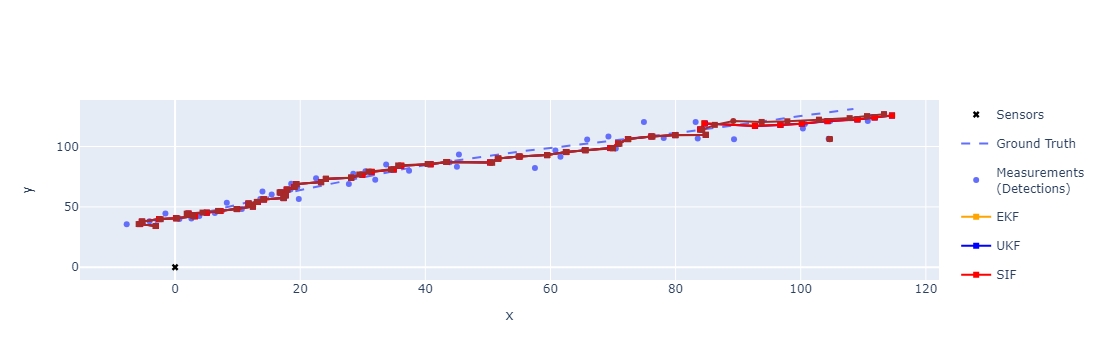

In [50]:
plotter.plot_tracks(tracks_EKF, [0, 2], track_label="EKF", line=dict(color="orange"),
                    uncertainty=False)
plotter.plot_tracks(tracks_UKF, [0, 2], track_label="UKF", line=dict(color="blue"),
                    uncertainty=False)
plotter.plot_tracks(tracks_SIF, [0, 2], track_label="SIF", line=dict(color="red"),
                    uncertainty=False)
#plotter.plot_tracks(tracks_EnKF, [0, 2], track_label="EnKF", line=dict(color="green"),
#                    uncertainty=False)
plotter.plot_tracks(tracks_PF, [0, 2], track_label="PF", line=dict(color="brown"),
                    uncertainty=False)
plotter.fig

## 4) Calculate and display metrics to show effectiveness of different tracking algorithms

The final part of this example is to calculate metrics that can determine how well each tracking
algorithm followed the target. None will be perfect due to the sensor measurement noise and error
in data association where multiple tracks meet, but some will perform better than others.

This section of the example follows code from the metrics example, which is also used in
the sensor management tutorials. More complete documentation can be found there.

Firstly, we calculate the Optimal Sub-Pattern Assignment (OSPA) distance at each time
step for each tracker. This is a measure of how far the calculated tracks are
from the ground truth. We first initialise the metrics before plotting:



In [51]:
from stonesoup.metricgenerator.ospametric import OSPAMetric

ospa_generator = OSPAMetric(c=40, p=1)

from stonesoup.metricgenerator.tracktotruthmetrics import SIAPMetrics
from stonesoup.measures import Euclidean

siap_generator = SIAPMetrics(position_measure=Euclidean((0, 2)),
                             velocity_measure=Euclidean((1, 3)))

from stonesoup.dataassociator.tracktotrack import TrackToTruth

associator = TrackToTruth(association_threshold=30)

from stonesoup.metricgenerator.uncertaintymetric import SumofCovarianceNormsMetric

uncertainty_generator = SumofCovarianceNormsMetric()

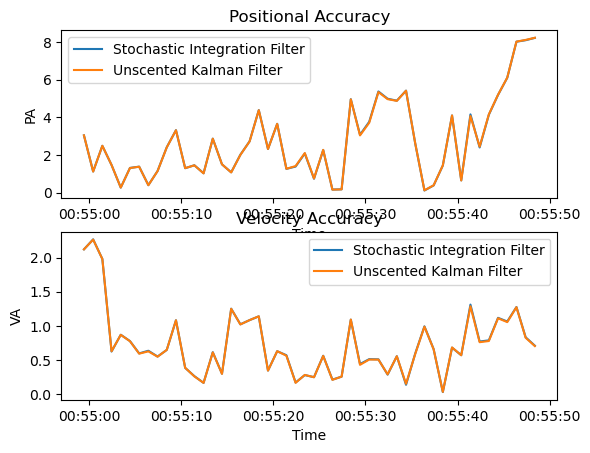

In [52]:
import matplotlib.pyplot as plt

from stonesoup.metricgenerator.manager import SimpleManager

metric_managerSIF = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                associator=associator)

metric_managerUKF = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                associator=associator)

metric_managerSIF.add_data(ground_truth, tracks_SIF)
metric_managerUKF.add_data(ground_truth, tracks_UKF)

metricsSIF = metric_managerSIF.generate_metrics()
metricsUKF = metric_managerUKF.generate_metrics()

fig, axes = plt.subplots(2)

times = metric_managerSIF.list_timestamps()

pa_metricSIF = metricsSIF['SIAP Position Accuracy at times']
va_metricSIF = metricsSIF['SIAP Velocity Accuracy at times']

pa_metricUKF = metricsUKF['SIAP Position Accuracy at times']
va_metricUKF = metricsUKF['SIAP Velocity Accuracy at times']

axes[0].set(title='Positional Accuracy', xlabel='Time', ylabel='PA')
axes[0].plot(times, [metric.value for metric in pa_metricSIF.value],
             label='Stochastic Integration Filter')
axes[0].plot(times, [metric.value for metric in pa_metricUKF.value],
             label='Unscented Kalman Filter')
axes[0].legend()

axes[1].set(title='Velocity Accuracy', xlabel='Time', ylabel='VA')
axes[1].plot(times, [metric.value for metric in va_metricSIF.value],
             label='Stochastic Integration Filter')
axes[1].plot(times, [metric.value for metric in va_metricUKF.value],
             label='Unscented Kalman Filter')
axes[1].legend()

Now we initialise the metric managers for each tracker:



In [53]:
from stonesoup.metricgenerator.manager import SimpleManager
# ##################################################

metric_manager_EKF = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                   associator=associator)
metric_manager_EKF.add_data(ground_truth, tracks_EKF)
metrics_EKF = metric_manager_EKF.generate_metrics()

# ##################################################

metric_manager_UKF = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                   associator=associator)
metric_manager_UKF.add_data(ground_truth, tracks_UKF)
metrics_UKF = metric_manager_UKF.generate_metrics()

# ##################################################

metric_manager_SIF = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                  associator=associator)
metric_manager_SIF.add_data(ground_truth, tracks_SIF)
metrics_SIF = metric_manager_SIF.generate_metrics()

# ##################################################

metric_manager_PF = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                  associator=associator)
metric_manager_PF.add_data(ground_truth, tracks_PF)
metrics_PF = metric_manager_PF.generate_metrics()

Now we can plot the OSPA distance for each tracker:



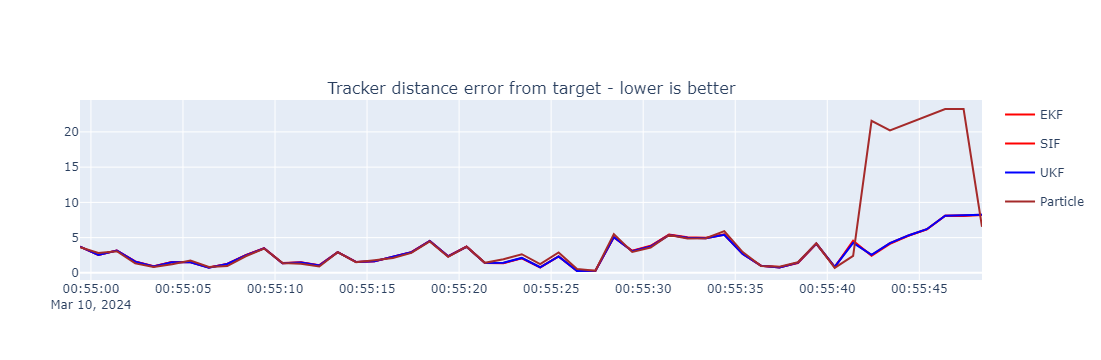

In [54]:
from plotly.subplots import make_subplots

ospa_metric_EKF = metrics_EKF['OSPA distances']
ospa_metric_UKF = metrics_UKF['OSPA distances']
ospa_metric_SIF = metrics_SIF['OSPA distances']
ospa_metric_PF = metrics_PF['OSPA distances']

fig = make_subplots(
    rows=1, cols=1,
    shared_xaxes=False,
    vertical_spacing=0.040,
    subplot_titles=['Tracker distance error from target - lower is better'])
fig.add_scatter(
    x=[i.timestamp for i in ospa_metric_EKF.value],
    y=[i.value for i in ospa_metric_EKF.value],
    name='EKF',
    legendgroup="orange",
    yaxis='y',
    row=1,
    col=1,
    showlegend=True,
    line_color='red',
)
fig.add_scatter(
    x=[i.timestamp for i in ospa_metric_SIF.value],
    y=[i.value for i in ospa_metric_SIF.value],
    name='SIF',
    legendgroup="red",
    yaxis='y',
    row=1,
    col=1,
    showlegend=True,
    line_color='red',
)
fig.add_scatter(
    x=[i.timestamp for i in ospa_metric_UKF.value],
    y=[i.value for i in ospa_metric_UKF.value],
    name='UKF',
    legendgroup="blue",
    yaxis='y',
    row=1,
    col=1,
    showlegend=True,
    line_color='blue',
)
fig.add_scatter(
    x=[i.timestamp for i in ospa_metric_PF.value],
    y=[i.value for i in ospa_metric_PF.value],
    name='Particle',
    legendgroup="brown",
    yaxis='y',
    row=1,
    col=1,
    showlegend=True,
    line_color='brown',
)


It can be seen that the EKF, UKF, and Particle Filter all behave very similarly,
whereas the ESIF has very poor relative performance. A singular performance metric is calculated
from this by summing the OSPA value over all timesteps:



In [55]:
# sum up distance error from ground truth over all timestamps
ospa_EKF_total = sum([ospa_metric_EKF.value[i].value for i in range(0,
                                                                    len(ospa_metric_EKF.value))])
ospa_UKF_total = sum([ospa_metric_UKF.value[i].value for i in range(0,
                                                                    len(ospa_metric_UKF.value))])
ospa_SIF_total = sum([ospa_metric_SIF.value[i].value for i in range(0,
                                                                    len(ospa_metric_SIF.value))])
ospa_PF_total = sum([ospa_metric_PF.value[i].value for i in range(0,
                                                                len(ospa_metric_PF.value))])
print("OSPA total value for EKF is ", f'{ospa_UKF_total:.3f}')
print("OSPA total value for UKF is ", f'{ospa_UKF_total:.3f}')
print("OSPA total value for SIF is ", f'{ospa_SIF_total:.3f}')
print("OSPA total value for PF is ", f'{ospa_UKF_total:.3f}')

OSPA total value for EKF is  147.793
OSPA total value for UKF is  147.793
OSPA total value for SIF is  147.953
OSPA total value for PF is  147.793


Monte Carlo Generation (I would like to dial in the above example simulation before running it many times)

In [75]:
def root_mean_square_error(ground_truths, tracks):
    for truth in ground_truths:
        for track in tracks:
            #truthState = np.zeros((4,len(track.states)))
            mse = np.zeros((4,len(track.states)))
            for ind in range(0,len(track.states)):
                a = track.states[ind].mean
                b = truth.states[ind].state_vector
                a = a.ravel()
                b = b.ravel()
                mse[:,ind] = np.power((a-b),2)
            return np.sqrt(mse)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


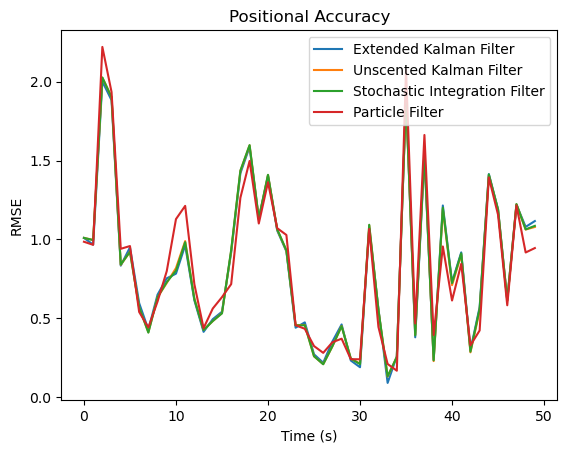

In [81]:
monte_carlo_iterations = 100

y_sum_EKF = np.zeros(np.array([i.value for i in ospa_metric_EKF.value]).shape)
y_sum_UKF = np.zeros(np.array([i.value for i in ospa_metric_SIF.value]).shape)
y_sum_SIF = np.zeros(y_sum_UKF.shape)
y_sum_PF = np.zeros(y_sum_UKF.shape)

rmseEKF = np.zeros([4,50])
rmseUKF = np.zeros([4,50])
rmseSIF = np.zeros([4,50])
rmseEnKF = np.zeros([4,50])

for i in range(monte_carlo_iterations):
    print(i+1)
    detector = PlatformDetectionSimulator(ground_truth_gen, platforms=[platform])
    detector, *detectors = tee(detector, 6)
    # Generate Ground Truth
    detections = set()
    ground_truth = set()
    for time, dets in detector:
        detections |= dets
        ground_truth |= ground_truth_gen.groundtruth_paths
    # Instantiate Trackers
    kalman_tracker_EKF = MultiTargetTracker(
    initiator=initiator_EKF,
    deleter=deleter,
    detector=detectors[0],
    data_associator=data_associator_EKF,
    updater=updater_EKF,
    )
    kalman_tracker_UKF = MultiTargetTracker(
    initiator=initiator_UKF,
    deleter=deleter,
    detector=detectors[1],
    data_associator=data_associator_UKF,
    updater=updater_UKF,
    )
    kalman_tracker_SIF = MultiTargetTracker(
    initiator=initiator_SIF,
    deleter=deleter,
    detector=detectors[2],
    data_associator=data_associator_SIF,
    updater=updater_SIF,
    )
    tracker_PF = MultiTargetTracker(
    initiator=initiator_PF,
    deleter=deleter,
    detector=detectors[3],
    data_associator=data_associator_PF,
    updater=updater_PF,
    )
    # Run Tracks
    tracks_EKF = set()
    for step, (time, current_tracks) in enumerate(kalman_tracker_EKF, 1):
        tracks_EKF.update(current_tracks)
    tracks_UKF = set()
    for step, (time, current_tracks) in enumerate(kalman_tracker_UKF, 1):
        tracks_UKF.update(current_tracks)
    tracks_SIF = set()
    for step, (time, current_tracks) in enumerate(kalman_tracker_SIF, 1):
        tracks_SIF.update(current_tracks)
    tracks_PF = set()
    for step, (time, current_tracks) in enumerate(tracker_PF, 1):
        tracks_PF.update(current_tracks)
    # Metrics Managers
    metric_manager_EKF = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                       associator=associator)
    metric_manager_EKF.add_data(ground_truth, tracks_EKF)
    metrics_EKF = metric_manager_EKF.generate_metrics()
    #
    metric_manager_UKF = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                       associator=associator)
    metric_manager_UKF.add_data(ground_truth, tracks_UKF)
    metrics_UKF = metric_manager_UKF.generate_metrics()
    #
    metric_manager_SIF = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                      associator=associator)
    metric_manager_SIF.add_data(ground_truth, tracks_SIF)
    metrics_SIF = metric_manager_SIF.generate_metrics()
    #
    metric_manager_PF = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                      associator=associator)
    metric_manager_PF.add_data(ground_truth, tracks_PF)
    metrics_PF = metric_manager_PF.generate_metrics()
    # Metric Generation
    ospa_metric_EKF = metrics_EKF['OSPA distances']
    ospa_metric_UKF = metrics_UKF['OSPA distances']
    ospa_metric_SIF = metrics_SIF['OSPA distances']
    ospa_metric_PF = metrics_PF['OSPA distances']
    y_sum_EKF =+ np.array([i.value for i in ospa_metric_EKF.value])
    y_sum_UKF =+ np.array([i.value for i in ospa_metric_UKF.value])
    y_sum_SIF =+ np.array([i.value for i in ospa_metric_SIF.value])
    y_sum_PF =+ np.array([i.value for i in ospa_metric_PF.value])

    rmseEKF_sum =+ root_mean_square_error(ground_truth, tracks_EKF)
    rmseUKF_sum =+ root_mean_square_error(ground_truth, tracks_UKF)
    rmseSIF_sum =+ root_mean_square_error(ground_truth, tracks_SIF)
    rmsePF_sum =+ root_mean_square_error(ground_truth, tracks_PF)


fig = make_subplots(
    rows=1, cols=1,
    shared_xaxes=False,
    vertical_spacing=0.040,
    subplot_titles=['Tracker distance error from target - lower is better'])
fig.add_scatter(
    x=[i.timestamp for i in ospa_metric_EKF.value],
    #y=[i.value for i in ospa_metric_EKF.value],
    y = y_sum_EKF / (monte_carlo_iterations),
    name='EKF',
    legendgroup="orange",
    yaxis='y',
    row=1,
    col=1,
    showlegend=True,
    line_color='orange',
)
fig.add_scatter(
    x=[i.timestamp for i in ospa_metric_SIF.value],
    #y=[i.value for i in ospa_metric_SIF.value],
    y = y_sum_SIF / (monte_carlo_iterations),
    name='SIF',
    legendgroup="red",
    yaxis='y',
    row=1,
    col=1,
    showlegend=True,
    line_color='red',
)
fig.add_scatter(
    x=[i.timestamp for i in ospa_metric_UKF.value],
    #y=[i.value for i in ospa_metric_UKF.value],
    y = y_sum_UKF / (monte_carlo_iterations),
    name='UKF',
    legendgroup="blue",
    yaxis='y',
    row=1,
    col=1,
    showlegend=True,
    line_color='blue',
)
fig.add_scatter(
    x=[i.timestamp for i in ospa_metric_PF.value],
    #y=[i.value for i in ospa_metric_PF.value],
    y = y_sum_PF / (monte_carlo_iterations),
    name='Particle',
    legendgroup="brown",
    yaxis='y',
    row=1,
    col=1,
    showlegend=True,
    line_color='brown',
)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1)

rmseEKF = rmseEKF_sum #/ monte_carlo_iterations
rmseUKF = rmseUKF_sum #/ monte_carlo_iterations
rmseSIF = rmseSIF_sum #/ monte_carlo_iterations
rmsePF = rmsePF_sum #/ monte_carlo_iterations

times = range(50)

axes.set(title='Positional Accuracy', xlabel='Time (s)', ylabel='RMSE')
axes.plot(times, np.mean(rmseEKF,0),
             label='Extended Kalman Filter')
axes.plot(times, np.mean(rmseUKF,0),
             label='Unscented Kalman Filter')
axes.plot(times, np.mean(rmseSIF,0),
             label='Stochastic Integration Filter')
axes.plot(times, np.mean(rmsePF,0),
             label='Particle Filter')
axes.legend()
